need to do - review colours for red, green and yellow
improve x-y coordinate stuff
work on get force stuff!

For some reason my shit is not working - might have to try simple approach of just going over it?

In [1]:
# Import all libraries!
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil
import time
import logging
import urx
from urx.robotiq_two_finger_gripper import Robotiq_Two_Finger_Gripper
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# from urx.urrtmon import URRTMonitor

#image: http://192.168.1.6:4242/current.jpg?type=color

cam_init_pos = [-0.00043183961977177887, -1.651595417653219, -1.226389233266012, -1.276344124470846, -4.72298783460726, 0.001785649568773806]
bucket_pos = [1.6486937999725342, -2.4073990027057093, -1.8858941237079065, -0.36886865297426397, -4.742553655301229, 0.0471811443567276]
hardcode_object_loc = [-0.024045769368306935, -1.8617809454547327, -1.511141602193014, -1.4511950651751917, -4.672266546879904, 0.047373268753290176]
bucket_pick = [-0.04573041597475225, -1.8159015814410608, -1.2815788427936, -1.4384973684894007, -4.67054266134371, 0.04719312861561775]

In [2]:
def get_color(event,x,y,flags,param):
    global refPt1,refPt2,max_H,max_S,max_V,min_H,min_S,min_V
    #count = 0
    
    #print 'it worked'
    if event == cv2.EVENT_LBUTTONDOWN:
        #cv2.circle(img,(x,y),100,(255,0,0),-1)
        refPt1 =[(x,y)]
        #print "x coord: " + str(mouseX)
        #print "y coord: " + str(mouseY)
        #print "hsv: " + str(HSV_img[mouseY,mouseX])
    elif event == cv2.EVENT_LBUTTONUP:
        refPt2 =[(x,y)]
        dist = int(np.sqrt((refPt2[0][0]-refPt1[0][0])**2+(refPt2[0][1]-refPt1[0][1])**2))
        print dist
        cv2.circle(img,refPt1[0],dist,(0,255,0),2)
        max_H = HSV_img[refPt1[0][1]][refPt1[0][0]][0]
        max_S = HSV_img[refPt1[0][1]][refPt1[0][0]][1]
        max_V = HSV_img[refPt1[0][1]][refPt1[0][0]][2]
        min_H = HSV_img[refPt1[0][1]][refPt1[0][0]][0]
        min_S = HSV_img[refPt1[0][1]][refPt1[0][0]][0]
        min_V = HSV_img[refPt1[0][1]][refPt1[0][0]][0]
        for i in range(-dist,dist):
            for j in range(-dist,dist):
                #print "H: " + str(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][0]) + " S: " + str(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][1]) + " V: " + str(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][2])
                if HSV_img[refPt1[0][1]][refPt1[0][0]][0] - 10 < HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][0]:
                    min_H = min(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][0],min_H)
                    min_S = min(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][1],min_S)
                    min_V = min(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][2],min_V)
                    max_S = max(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][1],max_S)
                    max_V = max(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][2],max_V)

                if HSV_img[refPt1[0][1]][refPt1[0][0]][0] + 10 > HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][0]:
                    max_H = max(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][0],max_H)
                    min_S = min(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][1],min_S)
                    min_V = min(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][2],min_V)
                    max_S = max(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][1],max_S)
                    max_V = max(HSV_img[refPt1[0][1]+i][refPt1[0][0]+j][2],max_V)
#         print "H: " + str(min_H) + ", " + str(max_H)
#         print "S: " + str(min_S) + ", " + str(max_S)
#         print "V: " + str(min_V) + ", " + str(max_V)

In [3]:
def teach_bins(rob):
    '''
    Allows user to move robot to placement of bins
    Also need to allow user to take photo of object!??
    '''
    colours = []
    bins = []
    n_bins = int(raw_input("Please enter the number of bins you have: "))
    for i in range(n_bins):
        rob.set_freedrive(1, timeout=60)
        colours.append(raw_input("Press color of bin when complete: "))
        bins.append(rob.getj())
        
    print("Completed all bins!")
    return [colours, bins]

def get_image():
    '''
    Recieve latest image and save it in a folder
    '''
    
    image_url = "http://192.168.1.6:4242/current.jpg?type=color"
    
    resp = requests.get(image_url, stream=True)
    # Open a local file with wb ( write binary ) permission.
    img_string = 'images/latest_image.jpg'
    local_file = open(img_string, 'wb')
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    resp.raw.decode_content = True
    # Copy the response stream raw data to local image file.
    shutil.copyfileobj(resp.raw, local_file)
    # Remove the image url response object.
    del resp
    
    im = cv2.imread('images/latest_image.jpg')
    height, width, _ = im.shape
    print("height is: " + str(height) + ", width is: " + str(width))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()
    
    print("image recieved")
    
    return [height, width]

def detect_photos(colour):
    '''
    Read in latest image and detect blobs of the given colour
    return the distance to the top left blob in form [X_from_center, Y_from_center] else returns None
    '''
    f = "images/latest_image.jpg"

    # two ranges because red stretchs over the Hue colour range
    
    ##RED
    lower_red_1 = (0,100,50)
    upper_red_1 = (5,255,255)

    lower_red_2 = (170,100,50)
    upper_red_2 = (180,255,255)
    
    ##GREEN
    lower_green = (45, 100, 50)
    upper_green = (65, 255, 255)
    
    ##YELLOW
    lower_yellow = (30, 100, 50)
    upper_yellow = (45, 255, 255)
    
    ##NEW
    lower_new = (int(min_H), 100, 50)
    upper_new = (int(max_H), 255, 255)
    print lower_new

    # reading in image to RGB and HSV
    img_RGB = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)

    if colour == 'red':

        # Create two masks
        mask1 = cv2.inRange(img_HSV, lower_red_1, upper_red_1)
        mask2 = cv2.inRange(img_HSV, lower_red_2, upper_red_2)

        # XOR masks
        mask = cv2.bitwise_xor(mask1, mask2)
    elif colour == 'green':
        mask = cv2.inRange(img_HSV, lower_green, upper_green)

    elif colour == 'yellow':
        mask = cv2.inRange(img_HSV, lower_yellow, upper_yellow)
        
    elif colour == 'new':
        mask = cv2.inRange(img_HSV, lower_new, upper_new)


    # bitwise and with image
    result = cv2.bitwise_and(img_HSV, img_HSV, mask=mask)


    # put median blur over the top
    median = cv2.medianBlur(mask,23)

    print("pixel count: " + str(cv2.countNonZero(median)))

    if cv2.countNonZero(median) < 2000:
        print("no more objects in scene of colour: " + colour)
        return None

    # find connected components
    ret, labels = cv2.connectedComponents(median)

    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    #########################################################
    ## Finding Centers!
    ret,thresh = cv2.threshold(median,127,255,0)

    # find contours in the binary image
    ___, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    distance_min = 100000
    for c in contours:
        # calculate moments for each contour
        M = cv2.moments(c)

        # calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(labeled_img, (cX, cY), 5, (255, 255, 255), -1)

            distance_new = np.sqrt(cX**2 + cY**2)
            if distance_new < distance_min:
                distance_min = distance_new
                X_top_left = cX
                Y_top_left = cY

            print("centerpoints at: x: " + str(cX) + " y: " + str(cY))

    print("top left points are: x: " + str(X_top_left) + " y: " + str(Y_top_left))

#     X_from_center = X_top_left - (640/2)
#     Y_from_center = Y_top_left - (480/2)

#     print("distance from center: x: " + str(X_from_center) + " y: " + str(Y_from_center))

    # print out figures
    figure = plt.figure(figsize=(20,20))
    plt.subplot(1, 4, 1)
    # mask
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 4, 2)
    # median blue
    plt.imshow(median)
    #original image
    plt.subplot(1, 4, 3)
    plt.imshow(img_RGB)
    # final 
    plt.subplot(1, 4, 4)
    plt.imshow(labeled_img)

    plt.show()

#     return [X_from_center, Y_from_center]
    return [X_top_left, Y_top_left]

def test_robot(a = 0.2, v = 0.3):
    '''
    Test to see if robot is behaving normally
    '''
    # connecting to robot and initialising gripper
    while(1):
        try:
            rob = urx.Robot("192.168.1.6", use_rt=True)
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            break
    
    robotiqgrip = Robotiq_Two_Finger_Gripper(rob)

    robotiqgrip.open_gripper()

    # move to initial position
    rob.movej(cam_init_pos, acc = a, vel = v)


    pose = rob.getj()
    print("robot tcp is at pose: ", pose)

    rob.close()

def go_to_start(rob):
    rob.movej(cam_init_pos, acc = a, vel = v)
    print("moved to init position")
    

def rob_connect():
    while(1):
        try:
            #rob = urx.Robot("192.168.1.6")
            rob = urx.Robot("192.168.1.6", use_rt=True)
        except:
            print("didnt connect, try again")
            time.sleep(1)
        else:
            robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
            return rob
    



def convert_to_mm(x, y, h, w):
    '''
    return mm from center!
    '''
#     x = x - (640/2)
#     y = y - (480/2)
    
    
#     x = ((44.0/640.0) / 100) * x
#     y = ((40.0/(480.0)) / 100) * y + 0.02
#     y = y / 1.2

    x = x - (w/2)
    y = y - (h/2)
    
    
    x = ((44.0/w) / 100) * x
    y = ((40.0/(h)) / 100) * y + 0.02
    y = y / 1.2
    
    print(x)
    print(y)
    return [x, y]





No handlers could be found for logger "ursecmon"


didnt connect, try again
moved to init position
height is: 480, width is: 640


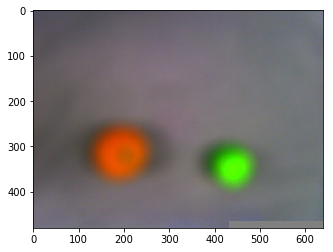

image recieved
0
41
H: 9, 15
Please enter the number of bins you have: 2
Press color of bin when complete: green
Press color of bin when complete: new
Completed all bins!
moved to init position
height is: 480, width is: 640


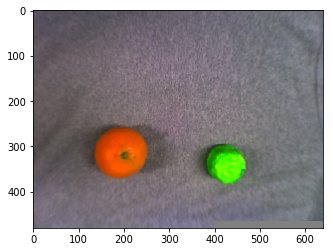

image recieved
(9, 100, 50)
pixel count: 5904
centerpoints at: x: 425 y: 338
top left points are: x: 425 y: 338


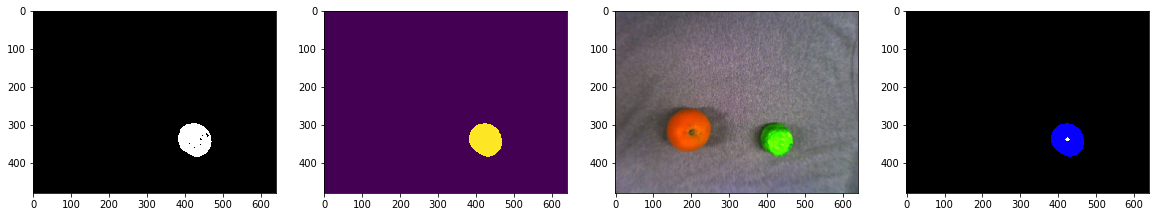

0.0721875
0.0847222222222
0.0721875
0.0847222222222
moved to init position
height is: 480, width is: 640


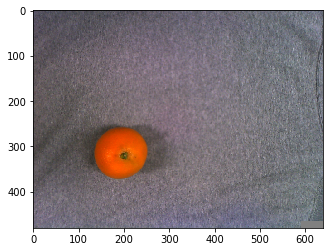

image recieved
(9, 100, 50)
pixel count: 0
no more objects in scene of colour: green
moved to init position
height is: 480, width is: 640


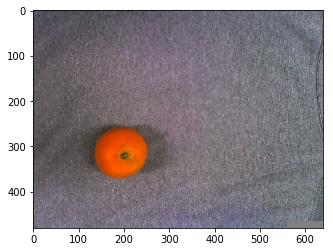

image recieved
(9, 100, 50)
pixel count: 10642
centerpoints at: x: 193 y: 314
top left points are: x: 193 y: 314


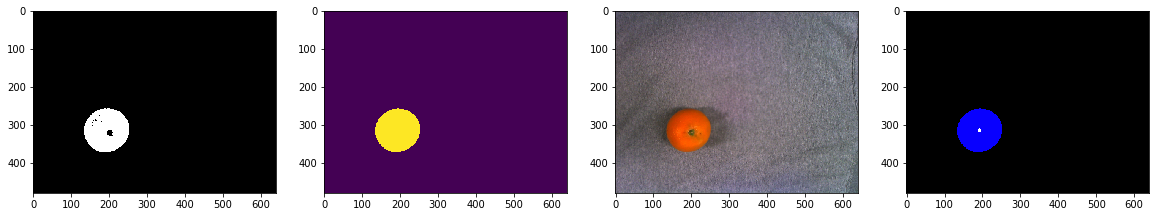

-0.0873125
0.0680555555556
-0.0873125
0.0680555555556
moved to init position
height is: 480, width is: 640


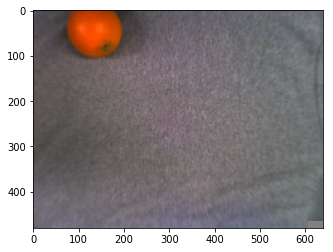

image recieved
(9, 100, 50)
pixel count: 10993
centerpoints at: x: 135 y: 48
top left points are: x: 135 y: 48


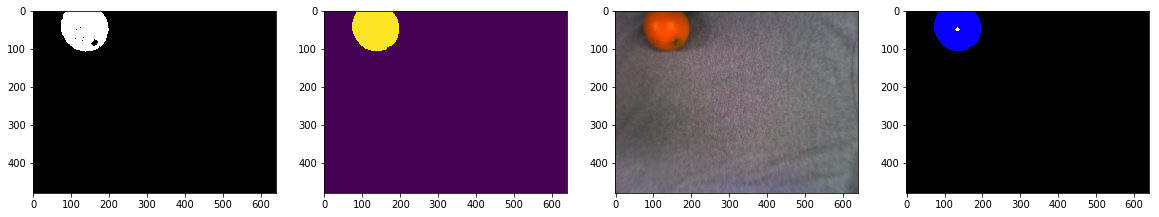

-0.1271875
-0.116666666667
-0.1271875
-0.116666666667
moved to init position
height is: 480, width is: 640


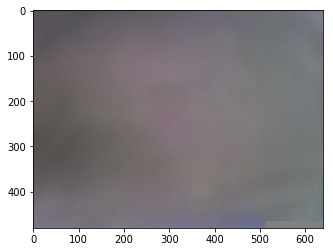

image recieved
(9, 100, 50)
pixel count: 0
no more objects in scene of colour: new
finishing program


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/ur5/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/opt/miniconda3/envs/ur5/lib/python2.7/site-packages/urx-0.11.0-py2.7.egg/urx/ursecmon.py", line 289, in run
    data = self._get_data()
  File "/opt/miniconda3/envs/ur5/lib/python2.7/site-packages/urx-0.11.0-py2.7.egg/urx/ursecmon.py", line 336, in _get_data
    tmp = self._s_secondary.recv(1024)
timeout: timed out



In [4]:
%matplotlib inline

# initalise
rob = rob_connect()
robotiqgrip = Robotiq_Two_Finger_Gripper(rob)
a = 0.7; v = 2


#######################################

robotiqgrip.open_gripper()
go_to_start(rob)
time.sleep(1)
h, w = get_image()
cv2.namedWindow('detect_HSV')
x = cv2.setMouseCallback('detect_HSV',get_color)
cv2.startWindowThread()
img = cv2.imread('images/latest_image.jpg')

HSV_img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
#cv2.imshow('HSV image', HSV_img)
while(1):
    cv2.imshow('detect_HSV',img)
    k = cv2.waitKey(20) & 0xFF
#     if k == ord('a'):
#     print "x coord: " + str(mouseX)
#     print "y coord: " + str(mouseY)
#     print "hsv: " + str(HSV_img[mouseX,mouseY])
    if k == ord('q'):
         
        break
cv2.destroyWindow('detect_HSV')
cv2.waitKey(1)
print "H: " + str(min_H) + ", " + str(max_H)
# print "S: " + str(min_S) + ", " + str(max_S)
# print "V: " + str(min_V) + ", " + str(max_V)
[colours, bins] = teach_bins(rob)
i = 0

while True:
    if i == len(colours):
        print("finishing program")
        break
        
    go_to_start(rob)
    time.sleep(1)
    h, w = get_image()
    distance = detect_photos(colours[i])
    
    if distance == None:
        i+=1
        continue
        

    [x_dist, y_dist] = convert_to_mm(distance[0], distance[1], h, w)
    print(x_dist)
    print(y_dist)

    rob.translate((y_dist-0.095, x_dist, -0.33), acc=a, vel=v)

    robotiqgrip.close_gripper()
    rob.movejs([cam_init_pos, bins[i]], acc = a, vel = v, radius=0.2)
    robotiqgrip.open_gripper()




#################3

# pose = rob.getj()
# print(pose)
# # pose[3] = pose[3] - 0.57
# # rob.movel(pose, acc = a, vel = v)

# rob.movel_tool([0, 0, 0, -0.43, 0, 0],acc=a, vel=v)

rob.close()